- K-MEAN 알고리즘을 쓰려고 했으나 속성의 개수가 많을수록 군집화 정확도가 떨어짐 -> PCA로 차원감소를 적용
- 반복을 수행하는 횟수가 많아질수록 수행 시간이 느려짐
- 몇개의 군집을 선택해야할지 가이드 하기가 어려움
- => DBCAN 알고리즘 사용
- 데이터의 밀도를 기반으로 군집을 찾는 방법, 특정 밀도 이상의 데이터가 있는 곳을 클로스터로 정의
- 클러스터의 수를 알 필요 없고, 비선형 클러스터 형태나 노이즈가 많은 데이터에도 잘 작동 

- 예측 모델 : XGBoost
- 과적합 방지하는 다양한 기법이 있고, 파라미터 조정을 통해 유연하게 사용 가능
- 대규모 데이터와 고차원 데이터에 매우 효과적

In [2]:
# pip install xgboost

In [3]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tabulate import tabulate 
import glob

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

<HR>

In [4]:
NABIS = pd.read_excel(r"C:\Hwan\NABIS\Final_NABIS.xlsx")
NABIS = pd.DataFrame(NABIS)
NABIS

,진료과목,연도,지역,의료기관,의료수가,가중치,지역 소아과 수,최종수가,강원특별자치도_건강보험,강원특별자치도_소아과 병원 수,...,인천광역시_소아과 의료인력 수,인천광역시_천명당 소아과 수,충청남도_건강보험,충청남도_소아과 병원 수,충청남도_소아과 의료인력 수,충청남도_천명당 소아과 수,충청북도_건강보험,충청북도_소아과 병원 수,충청북도_소아과 의료인력 수,충청북도_천명당 소아과 수
0,머리의 열린상처,2019,서울특별시,병원,186752,74.9,8032,13987724.8,1491120,864,...,1218,0.202236,2135182,996,679,0.113751,1589662,816,542,0.125230
1,머리의 열린상처,2019,서울특별시,의원,186752,83.4,8032,15575116.8,1491120,864,...,1218,0.202236,2135182,996,679,0.113751,1589662,816,542,0.125230
2,머리의 열린상처,2019,부산광역시,병원,186752,74.9,2172,13987724.8,1491120,864,...,1218,0.202236,2135182,996,679,0.113751,1589662,816,542,0.125230
3,머리의 열린상처,2019,부산광역시,의원,186752,83.4,2172,15575116.8,1491120,864,...,1218,0.202236,2135182,996,679,0.113751,1589662,816,542,0.125230
4,머리의 열린상처,2019,대구광역시,병원,186752,74.9,1816,13987724.8,1491120,864,...,1218,0.202236,2135182,996,679,0.113751,1589662,816,542,0.125230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,급성 세기관지염,2022,강원특별자치도,의원,1090378,90.2,864,98352095.6,1503671,904,...,1253,0.187899,2157366,1044,749,0.119396,1598867,868,593,0.133703
1228,급성 세기관지염,2022,충청북도,병원,1090378,78.4,816,85485635.2,1503671,904,...,1253,0.187899,2157366,1044,749,0.119396,1598867,868,593,0.133703
1229,급성 세기관지염,2022,충청북도,의원,1090378,90.2,816,98352095.6,1503671,904,...,1253,0.187899,2157366,1044,749,0.119396,1598867,868,593,0.133703
1230,급성 세기관지염,2022,충청남도,병원,1090378,78.4,996,85485635.2,1503671,904,...,1253,0.187899,2157366,1044,749,0.119396,1598867,868,593,0.133703


In [5]:
NABIS.isna().sum()

진료과목                  0
연도                    0
지역                    0
의료기관                  0
의료수가                  0
가중치                   0
지역 소아과 수              0
최종수가                  0
강원특별자치도_건강보험          0
강원특별자치도_소아과 병원 수      0
강원특별자치도_소아과 의료인력 수    0
강원특별자치도_천명당 소아과 수     0
경기도_건강보험              0
경기도_소아과 병원 수          0
경기도_소아과 의료인력 수        0
경기도_천명당 소아과 수         0
광주광역시_건강보험            0
광주광역시_소아과 병원 수        0
광주광역시_소아과 의료인력 수      0
광주광역시_천명당 소아과 수       0
대구광역시_건강보험            0
대구광역시_소아과 병원 수        0
대구광역시_소아과 의료인력 수      0
대구광역시_천명당 소아과 수       0
대전광역시_건강보험            0
대전광역시_소아과 병원 수        0
대전광역시_소아과 의료인력 수      0
대전광역시_천명당 소아과 수       0
부산광역시_건강보험            0
부산광역시_소아과 병원 수        0
부산광역시_소아과 의료인력 수      0
부산광역시_천명당 소아과 수       0
서울특별시_건강보험            0
서울특별시_소아과 병원 수        0
서울특별시_소아과 의료인력 수      0
서울특별시_천명당 소아과 수       0
울산광역시_건강보험            0
울산광역시_소아과 병원 수        0
울산광역시_소아과 의료인력 수      0
울산광역시_천명당 소아과 수       0
인천광역시_건강보험            0
인천광역시_소아과 병원 수  

In [6]:
NABIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   진료과목                1232 non-null   object 
 1   연도                  1232 non-null   int64  
 2   지역                  1232 non-null   object 
 3   의료기관                1232 non-null   object 
 4   의료수가                1232 non-null   int64  
 5   가중치                 1232 non-null   float64
 6   지역 소아과 수            1232 non-null   int64  
 7   최종수가                1232 non-null   float64
 8   강원특별자치도_건강보험        1232 non-null   int64  
 9   강원특별자치도_소아과 병원 수    1232 non-null   int64  
 10  강원특별자치도_소아과 의료인력 수  1232 non-null   int64  
 11  강원특별자치도_천명당 소아과 수   1232 non-null   float64
 12  경기도_건강보험            1232 non-null   int64  
 13  경기도_소아과 병원 수        1232 non-null   int64  
 14  경기도_소아과 의료인력 수      1232 non-null   int64  
 15  경기도_천명당 소아과 수       1232 non-null   float64
 16  광주광역시_

In [7]:
from sklearn.preprocessing import LabelEncoder

orderLe = LabelEncoder()
regionLe = LabelEncoder()

NABIS['진료과목_인코딩'] = orderLe.fit_transform(NABIS['진료과목'])
NABIS['지역_인코딩'] = regionLe.fit_transform(NABIS['지역'])

# 병원은 0, 의원 1
NABIS['의료기관_인코딩'] = NABIS['의료기관'].apply(lambda x: 0 if x == '병원' else 1)

NABIS

,진료과목,연도,지역,의료기관,의료수가,가중치,지역 소아과 수,최종수가,강원특별자치도_건강보험,강원특별자치도_소아과 병원 수,...,충청남도_소아과 병원 수,충청남도_소아과 의료인력 수,충청남도_천명당 소아과 수,충청북도_건강보험,충청북도_소아과 병원 수,충청북도_소아과 의료인력 수,충청북도_천명당 소아과 수,진료과목_인코딩,지역_인코딩,의료기관_인코딩
0,머리의 열린상처,2019,서울특별시,병원,186752,74.9,8032,13987724.8,1491120,864,...,996,679,0.113751,1589662,816,542,0.125230,10,6,0
1,머리의 열린상처,2019,서울특별시,의원,186752,83.4,8032,15575116.8,1491120,864,...,996,679,0.113751,1589662,816,542,0.125230,10,6,1
2,머리의 열린상처,2019,부산광역시,병원,186752,74.9,2172,13987724.8,1491120,864,...,996,679,0.113751,1589662,816,542,0.125230,10,5,0
3,머리의 열린상처,2019,부산광역시,의원,186752,83.4,2172,15575116.8,1491120,864,...,996,679,0.113751,1589662,816,542,0.125230,10,5,1
4,머리의 열린상처,2019,대구광역시,병원,186752,74.9,1816,13987724.8,1491120,864,...,996,679,0.113751,1589662,816,542,0.125230,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,급성 세기관지염,2022,강원특별자치도,의원,1090378,90.2,864,98352095.6,1503671,904,...,1044,749,0.119396,1598867,868,593,0.133703,2,0,1
1228,급성 세기관지염,2022,충청북도,병원,1090378,78.4,816,85485635.2,1503671,904,...,1044,749,0.119396,1598867,868,593,0.133703,2,10,0
1229,급성 세기관지염,2022,충청북도,의원,1090378,90.2,816,98352095.6,1503671,904,...,1044,749,0.119396,1598867,868,593,0.133703,2,10,1
1230,급성 세기관지염,2022,충청남도,병원,1090378,78.4,996,85485635.2,1503671,904,...,1044,749,0.119396,1598867,868,593,0.133703,2,9,0


In [8]:
NABIS.drop(['진료과목', '지역', '의료기관'], axis=1, inplace=True)

NABIS

,연도,의료수가,가중치,지역 소아과 수,최종수가,강원특별자치도_건강보험,강원특별자치도_소아과 병원 수,강원특별자치도_소아과 의료인력 수,강원특별자치도_천명당 소아과 수,경기도_건강보험,...,충청남도_소아과 병원 수,충청남도_소아과 의료인력 수,충청남도_천명당 소아과 수,충청북도_건강보험,충청북도_소아과 병원 수,충청북도_소아과 의료인력 수,충청북도_천명당 소아과 수,진료과목_인코딩,지역_인코딩,의료기관_인코딩
0,2019,186752,74.9,8032,13987724.8,1491120,864,527,0.142105,13413979,...,996,679,0.113751,1589662,816,542,0.125230,10,6,0
1,2019,186752,83.4,8032,15575116.8,1491120,864,527,0.142105,13413979,...,996,679,0.113751,1589662,816,542,0.125230,10,6,1
2,2019,186752,74.9,2172,13987724.8,1491120,864,527,0.142105,13413979,...,996,679,0.113751,1589662,816,542,0.125230,10,5,0
3,2019,186752,83.4,2172,15575116.8,1491120,864,527,0.142105,13413979,...,996,679,0.113751,1589662,816,542,0.125230,10,5,1
4,2019,186752,74.9,1816,13987724.8,1491120,864,527,0.142105,13413979,...,996,679,0.113751,1589662,816,542,0.125230,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,2022,1090378,90.2,864,98352095.6,1503671,904,618,0.148003,13857593,...,1044,749,0.119396,1598867,868,593,0.133703,2,0,1
1228,2022,1090378,78.4,816,85485635.2,1503671,904,618,0.148003,13857593,...,1044,749,0.119396,1598867,868,593,0.133703,2,10,0
1229,2022,1090378,90.2,816,98352095.6,1503671,904,618,0.148003,13857593,...,1044,749,0.119396,1598867,868,593,0.133703,2,10,1
1230,2022,1090378,78.4,996,85485635.2,1503671,904,618,0.148003,13857593,...,1044,749,0.119396,1598867,868,593,0.133703,2,9,0


In [27]:
NABIS.columns

Index(['연도', '의료수가', '가중치', '지역 소아과 수', '최종수가', '강원특별자치도_건강보험',
       '강원특별자치도_소아과 병원 수', '강원특별자치도_소아과 의료인력 수', '강원특별자치도_천명당 소아과 수',
       '경기도_건강보험', '경기도_소아과 병원 수', '경기도_소아과 의료인력 수', '경기도_천명당 소아과 수',
       '광주광역시_건강보험', '광주광역시_소아과 병원 수', '광주광역시_소아과 의료인력 수', '광주광역시_천명당 소아과 수',
       '대구광역시_건강보험', '대구광역시_소아과 병원 수', '대구광역시_소아과 의료인력 수', '대구광역시_천명당 소아과 수',
       '대전광역시_건강보험', '대전광역시_소아과 병원 수', '대전광역시_소아과 의료인력 수', '대전광역시_천명당 소아과 수',
       '부산광역시_건강보험', '부산광역시_소아과 병원 수', '부산광역시_소아과 의료인력 수', '부산광역시_천명당 소아과 수',
       '서울특별시_건강보험', '서울특별시_소아과 병원 수', '서울특별시_소아과 의료인력 수', '서울특별시_천명당 소아과 수',
       '울산광역시_건강보험', '울산광역시_소아과 병원 수', '울산광역시_소아과 의료인력 수', '울산광역시_천명당 소아과 수',
       '인천광역시_건강보험', '인천광역시_소아과 병원 수', '인천광역시_소아과 의료인력 수', '인천광역시_천명당 소아과 수',
       '충청남도_건강보험', '충청남도_소아과 병원 수', '충청남도_소아과 의료인력 수', '충청남도_천명당 소아과 수',
       '충청북도_건강보험', '충청북도_소아과 병원 수', '충청북도_소아과 의료인력 수', '충청북도_천명당 소아과 수',
       '진료과목_인코딩', '지역_인코딩', '의료기관_인코딩', '최종수가_표준화', 'DBSCAN 군집', 'K-MEAN 군집'],
      dtype='object')

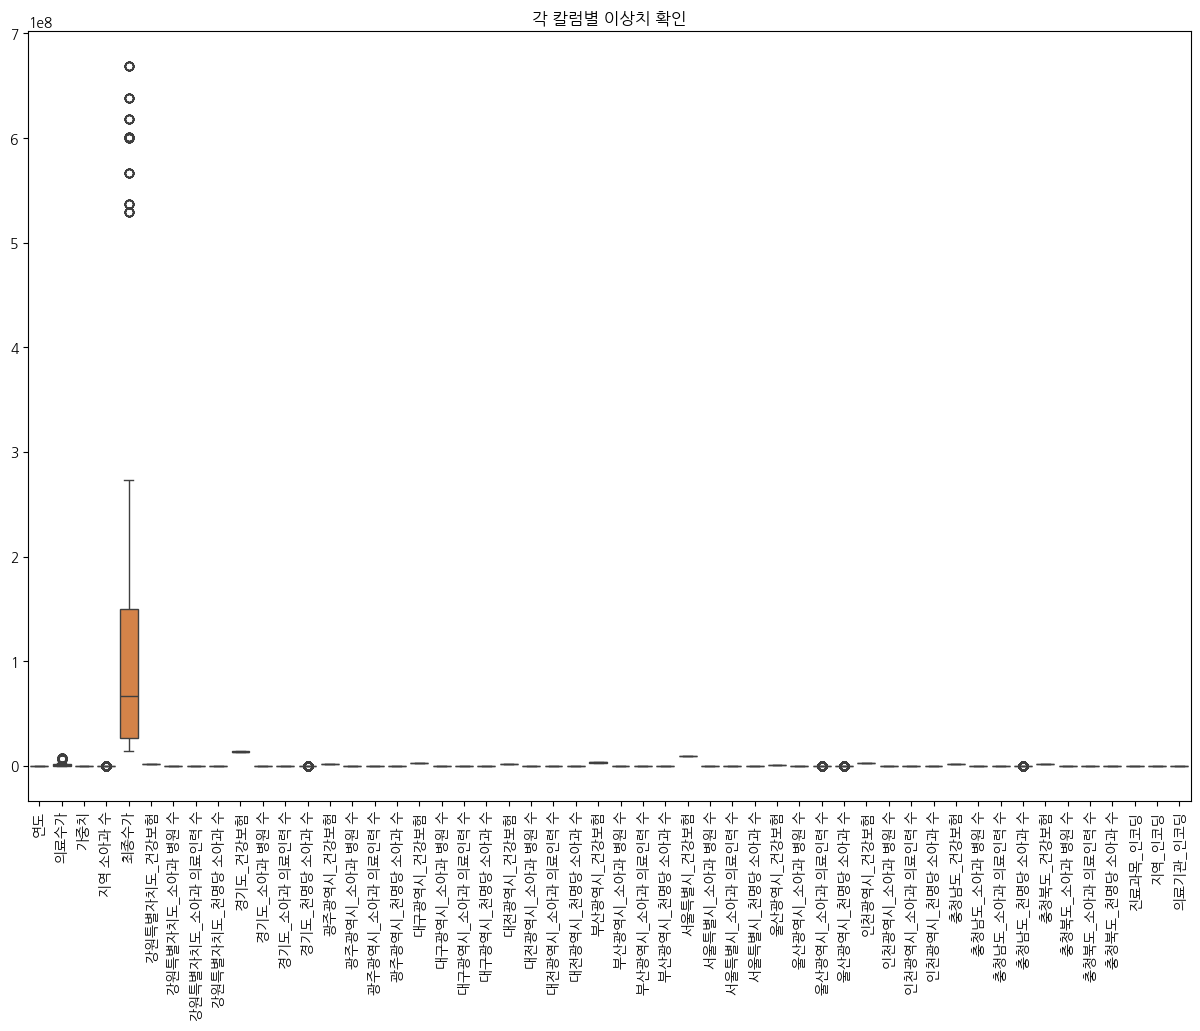

In [9]:
# 이상치 확인
plt.figure(figsize=(15, 10))
sns.boxplot(data=NABIS)
plt.xticks(rotation=90)
plt.title('각 칼럼별 이상치 확인')
plt.show()

In [10]:
# 이상치를 포함하고 있어도 효과적인 DBSCAN 알고리즘 사용 
# 스케일 조정으로 더욱 긍정적인 값을 기대하기 위해 스케일링 사용 

In [11]:
# data 표준화 - StandardScaler
scaler = StandardScaler()
NABIS['최종수가_표준화'] = scaler.fit_transform(NABIS[['최종수가']])

NABIS

,연도,의료수가,가중치,지역 소아과 수,최종수가,강원특별자치도_건강보험,강원특별자치도_소아과 병원 수,강원특별자치도_소아과 의료인력 수,강원특별자치도_천명당 소아과 수,경기도_건강보험,...,충청남도_소아과 의료인력 수,충청남도_천명당 소아과 수,충청북도_건강보험,충청북도_소아과 병원 수,충청북도_소아과 의료인력 수,충청북도_천명당 소아과 수,진료과목_인코딩,지역_인코딩,의료기관_인코딩,최종수가_표준화
0,2019,186752,74.9,8032,13987724.8,1491120,864,527,0.142105,13413979,...,679,0.113751,1589662,816,542,0.125230,10,6,0,-0.718750
1,2019,186752,83.4,8032,15575116.8,1491120,864,527,0.142105,13413979,...,679,0.113751,1589662,816,542,0.125230,10,6,1,-0.707978
2,2019,186752,74.9,2172,13987724.8,1491120,864,527,0.142105,13413979,...,679,0.113751,1589662,816,542,0.125230,10,5,0,-0.718750
3,2019,186752,83.4,2172,15575116.8,1491120,864,527,0.142105,13413979,...,679,0.113751,1589662,816,542,0.125230,10,5,1,-0.707978
4,2019,186752,74.9,1816,13987724.8,1491120,864,527,0.142105,13413979,...,679,0.113751,1589662,816,542,0.125230,10,3,0,-0.718750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,2022,1090378,90.2,864,98352095.6,1503671,904,618,0.148003,13857593,...,749,0.119396,1598867,868,593,0.133703,2,0,1,-0.146280
1228,2022,1090378,78.4,816,85485635.2,1503671,904,618,0.148003,13857593,...,749,0.119396,1598867,868,593,0.133703,2,10,0,-0.233587
1229,2022,1090378,90.2,816,98352095.6,1503671,904,618,0.148003,13857593,...,749,0.119396,1598867,868,593,0.133703,2,10,1,-0.146280
1230,2022,1090378,78.4,996,85485635.2,1503671,904,618,0.148003,13857593,...,749,0.119396,1598867,868,593,0.133703,2,9,0,-0.233587


In [12]:
features = NABIS[['진료과목_인코딩', '지역_인코딩', '의료기관_인코딩', '최종수가_표준화', '지역 소아과 수']]

# eps: 두 샘플이 같은 군집에 속한다고 간주하기 위한 최대 거리
# min_samples: 한 점을 핵심 포인트로 간주하기 위한 최소 샘플 수
dbscan = DBSCAN(eps=0.4, min_samples=10)

NABIS['DBSCAN 군집'] = dbscan.fit_predict(features)

Goonjib = './군집화 결과.xlsx'
NABIS.to_excel(Goonjib, index=False)

NABIS['DBSCAN 군집'].value_counts()

DBSCAN 군집
-1    1232
Name: count, dtype: int64

In [13]:
from sklearn.cluster import KMeans

# n_clusters: 군집 개수를 설정 
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

NABIS['K-MEAN 군집'] = kmeans.fit_predict(features)

KGoonjib = './K-MEAN 군집화 결과.xlsx'
NABIS.to_excel(KGoonjib, index=False)

NABIS['K-MEAN 군집'].value_counts()


K-MEAN 군집
0    224
2    112
3    112
5    112
7    112
8    112
4    112
1    112
9    112
6    112
Name: count, dtype: int64

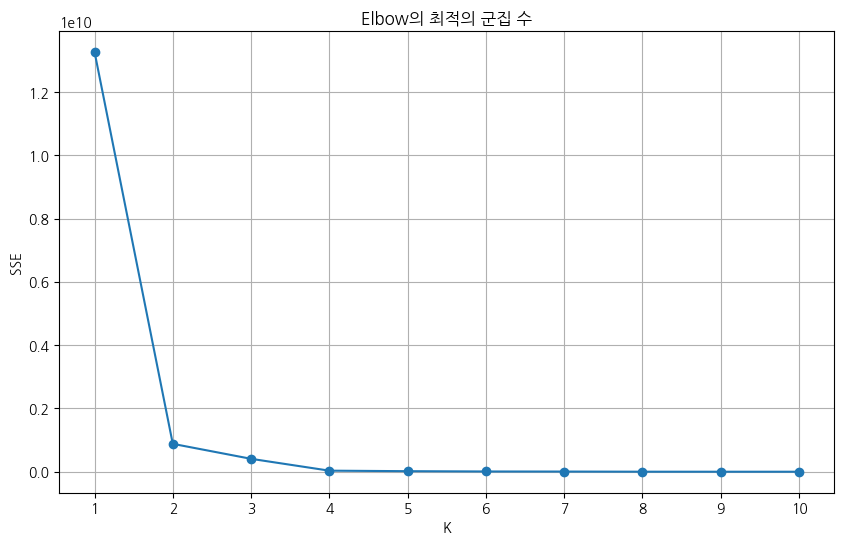

In [14]:
# Elbow 방법으로 SSE(군집내 제곱합)을 계산하여 최적의 군집 수 찾기
sse = []  
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)  

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow의 최적의 군집 수')
plt.xticks(k_range)
plt.grid(True)
plt.show()

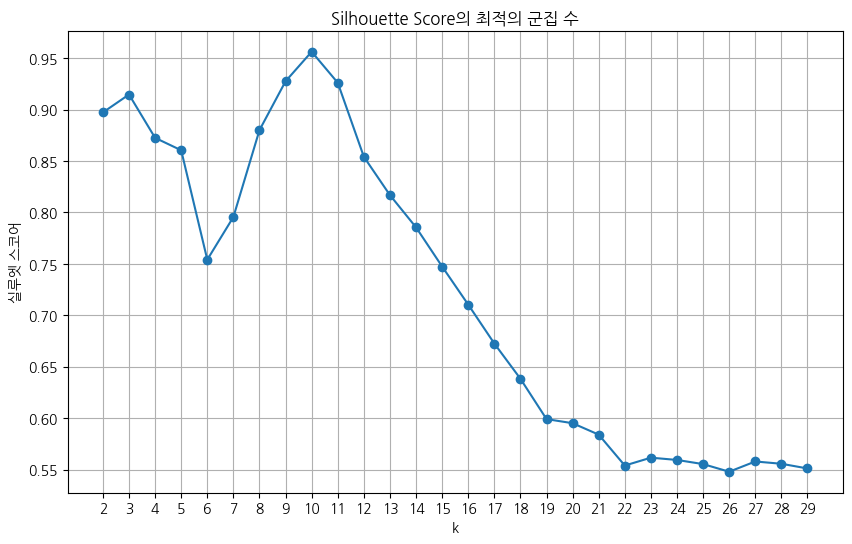

In [15]:
from sklearn.metrics import silhouette_score

# 실루엣 계수로 최적의 군집 수 찾기
silhouette_scores = []
k_range = range(2, 30)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('k')
plt.ylabel('실루엣 스코어')
plt.title('Silhouette Score의 최적의 군집 수')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [16]:
NABIS

,연도,의료수가,가중치,지역 소아과 수,최종수가,강원특별자치도_건강보험,강원특별자치도_소아과 병원 수,강원특별자치도_소아과 의료인력 수,강원특별자치도_천명당 소아과 수,경기도_건강보험,...,충청북도_건강보험,충청북도_소아과 병원 수,충청북도_소아과 의료인력 수,충청북도_천명당 소아과 수,진료과목_인코딩,지역_인코딩,의료기관_인코딩,최종수가_표준화,DBSCAN 군집,K-MEAN 군집
0,2019,186752,74.9,8032,13987724.8,1491120,864,527,0.142105,13413979,...,1589662,816,542,0.125230,10,6,0,-0.718750,-1,2
1,2019,186752,83.4,8032,15575116.8,1491120,864,527,0.142105,13413979,...,1589662,816,542,0.125230,10,6,1,-0.707978,-1,2
2,2019,186752,74.9,2172,13987724.8,1491120,864,527,0.142105,13413979,...,1589662,816,542,0.125230,10,5,0,-0.718750,-1,3
3,2019,186752,83.4,2172,15575116.8,1491120,864,527,0.142105,13413979,...,1589662,816,542,0.125230,10,5,1,-0.707978,-1,3
4,2019,186752,74.9,1816,13987724.8,1491120,864,527,0.142105,13413979,...,1589662,816,542,0.125230,10,3,0,-0.718750,-1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,2022,1090378,90.2,864,98352095.6,1503671,904,618,0.148003,13857593,...,1598867,868,593,0.133703,2,0,1,-0.146280,-1,9
1228,2022,1090378,78.4,816,85485635.2,1503671,904,618,0.148003,13857593,...,1598867,868,593,0.133703,2,10,0,-0.233587,-1,6
1229,2022,1090378,90.2,816,98352095.6,1503671,904,618,0.148003,13857593,...,1598867,868,593,0.133703,2,10,1,-0.146280,-1,6
1230,2022,1090378,78.4,996,85485635.2,1503671,904,618,0.148003,13857593,...,1598867,868,593,0.133703,2,9,0,-0.233587,-1,0



군집별 데이터 수:
 K-MEAN 군집
0    224
2    112
3    112
5    112
7    112
8    112
4    112
1    112
9    112
6    112
Name: count, dtype: int64

군집별 평균값:
                연도          의료수가     가중치  지역 소아과 수          최종수가  강원특별자치도_건강보험  \
K-MEAN 군집                                                                       
0          2020.5  1.467406e+06  81.725    1000.0  1.199092e+08     1497294.5   
1          2020.5  1.467406e+06  81.725   10940.0  1.199092e+08     1497294.5   
2          2020.5  1.467406e+06  81.725    8032.0  1.199092e+08     1497294.5   
3          2020.5  1.467406e+06  81.725    2172.0  1.199092e+08     1497294.5   
4          2020.5  1.467406e+06  81.725     580.0  1.199092e+08     1497294.5   
5          2020.5  1.467406e+06  81.725    1816.0  1.199092e+08     1497294.5   
6          2020.5  1.467406e+06  81.725     816.0  1.199092e+08     1497294.5   
7          2020.5  1.467406e+06  81.725    2388.0  1.199092e+08     1497294.5   
8          2020.5  1.467406e+06  81.725 

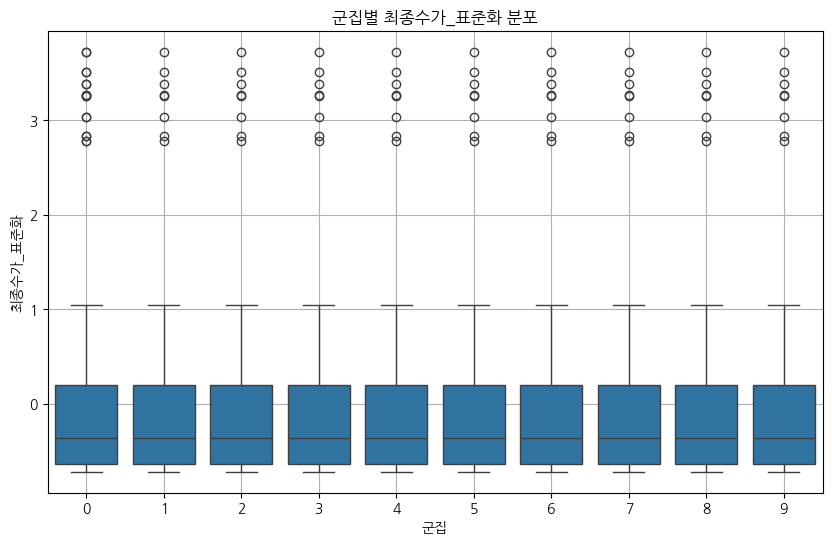

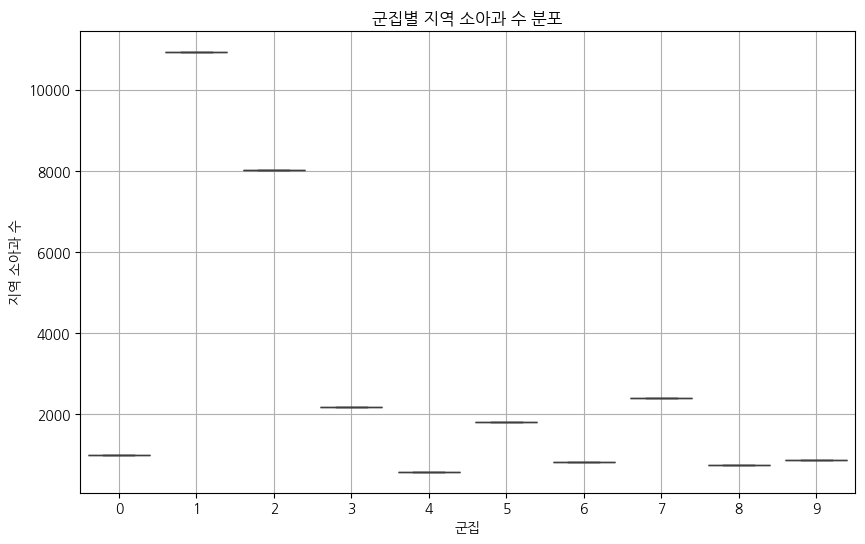

In [17]:
# k-mean 군집화 분석 

Kcluster_counts = NABIS['K-MEAN 군집'].value_counts()
print("\n군집별 데이터 수:\n", Kcluster_counts)

Kcluster_means = NABIS.groupby('K-MEAN 군집').mean()
print("\n군집별 평균값:\n", Kcluster_means)

plt.figure(figsize=(10, 6))
sns.boxplot(x='K-MEAN 군집', y='최종수가_표준화', data=NABIS)
plt.title('군집별 최종수가_표준화 분포')
plt.xlabel('군집')
plt.ylabel('최종수가_표준화')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='K-MEAN 군집', y='지역 소아과 수', data=NABIS)
plt.title('군집별 지역 소아과 수 분포')
plt.xlabel('군집')
plt.ylabel('지역 소아과 수')
plt.grid(True)
plt.show()


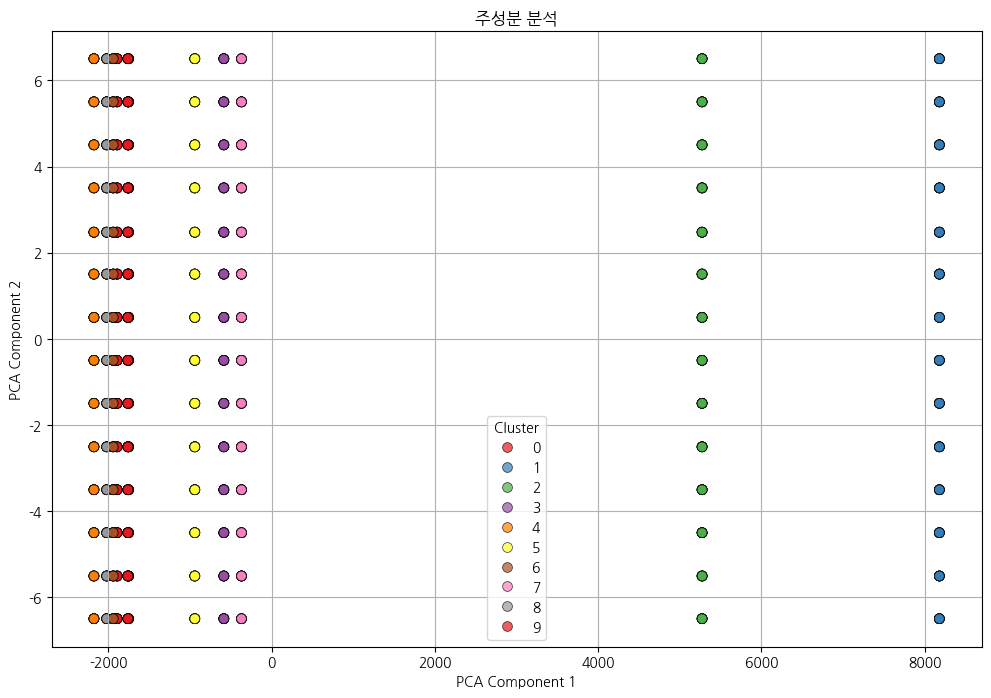

In [18]:
# PCA
from sklearn.decomposition import PCA
NABIS1 = NABIS.copy()

# 2차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

NABIS1['PCA1'] = pca_result[:, 0]
NABIS1['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='K-MEAN 군집', palette='Set1', data=NABIS1, s=50, alpha=0.7, edgecolor='k')
plt.title('주성분 분석')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

[0]	validation_0-rmse:3246.02728	validation_1-rmse:3264.55367
[1]	validation_0-rmse:3213.90206	validation_1-rmse:3232.25590
[2]	validation_0-rmse:3182.09489	validation_1-rmse:3200.27789
[3]	validation_0-rmse:3150.60269	validation_1-rmse:3168.61659
[4]	validation_0-rmse:3119.42260	validation_1-rmse:3137.26907
[5]	validation_0-rmse:3088.55107	validation_1-rmse:3106.23181
[6]	validation_0-rmse:3057.98545	validation_1-rmse:3075.50212
[7]	validation_0-rmse:3027.72246	validation_1-rmse:3045.07671


[8]	validation_0-rmse:2997.75911	validation_1-rmse:3014.95257
[9]	validation_0-rmse:2968.09257	validation_1-rmse:2985.12686
[10]	validation_0-rmse:2938.71990	validation_1-rmse:2955.59662
[11]	validation_0-rmse:2909.63789	validation_1-rmse:2926.35863
[12]	validation_0-rmse:2880.84418	validation_1-rmse:2897.41049
[13]	validation_0-rmse:2852.33551	validation_1-rmse:2868.74894
[14]	validation_0-rmse:2824.10929	validation_1-rmse:2840.37139
[15]	validation_0-rmse:2796.16252	validation_1-rmse:2812.27481
[16]	validation_0-rmse:2768.49254	validation_1-rmse:2784.45650
[17]	validation_0-rmse:2741.09657	validation_1-rmse:2756.91372
[18]	validation_0-rmse:2713.97206	validation_1-rmse:2729.64385
[19]	validation_0-rmse:2687.11607	validation_1-rmse:2702.64397
[20]	validation_0-rmse:2660.52615	validation_1-rmse:2675.91161
[21]	validation_0-rmse:2634.19965	validation_1-rmse:2649.44410
[22]	validation_0-rmse:2608.13397	validation_1-rmse:2623.23881
[23]	validation_0-rmse:2582.32634	validation_1-rmse:2597.

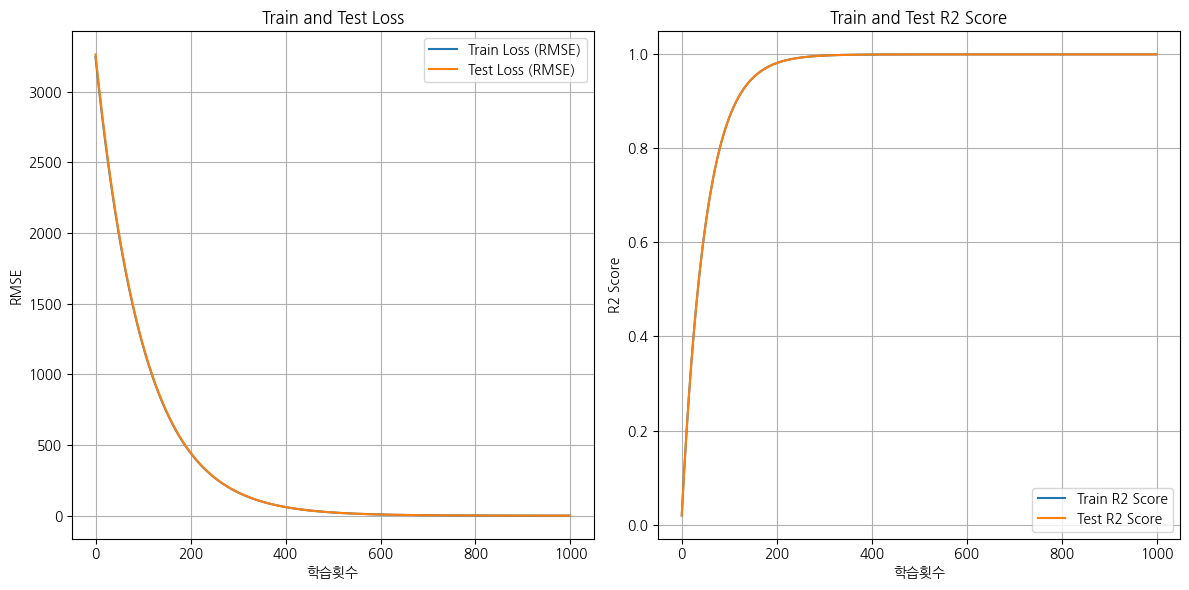


최종 Mean Squared Error: 0.03
최종 R2 Score: 1.00


c:\Users\hwans\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [26]:
# MODEL 학습

X = NABIS[['진료과목_인코딩', '지역_인코딩', '의료기관_인코딩', '최종수가_표준화', 'K-MEAN 군집']]
y = NABIS['지역 소아과 수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

evals_result = xgb_model.evals_result()
train_loss = evals_result['validation_0']['rmse']
test_loss = evals_result['validation_1']['rmse']

train_r2_scores = []
test_r2_scores = []

for i in range(len(train_loss)):
    y_train_pred = xgb_model.predict(X_train, iteration_range=(0, i + 1))
    y_test_pred = xgb_model.predict(X_test, iteration_range=(0, i + 1))
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss (RMSE)')
plt.plot(test_loss, label='Test Loss (RMSE)')
plt.xlabel('학습횟수')
plt.ylabel('RMSE')
plt.title('Train and Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_r2_scores, label='Train R2 Score')
plt.plot(test_r2_scores, label='Test R2 Score')
plt.xlabel('학습횟수')
plt.ylabel('R2 Score')
plt.title('Train and Test R2 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n최종 Mean Squared Error: {mse:.2f}")
print(f"최종 R2 Score: {r2:.2f}")

xgb_model.save_model('./xgboost_model.model')